# Exercise 4: Short-time Fourier Transform

Doing this exercise you will learn about the concept of the main lobe width of the spectrum of a window and you will better understand the short-time Fourier transform (STFT). You will also use the STFT to extract basic rhythm related information from an audio signal, implementing an onset detection function, which is one of the rhythm descriptors often used in music information retrieval to detect onsets of acoustic events. 

There are four parts in this exercise. 1) Extracting the main lobe of the spectrum of a window, 2) Measuring noise in the reconstructed signal using the STFT model, 3) Computing band-wise energy envelopes of a signal, 4) Computing an onset detection function.


### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated. 
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum. 

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases} 
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

The function `extract_main_lobe()` should extract the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum you should take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2). 

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function should return a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array you should include the samples corresponding to both the local minimas across the main lobe. 

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.

NOTE: You can approach this task by writing code to find the indices of the local minimas across the main lobe.

_Tip:_ `log10(0)` is not well defined, so its a common practice to add a small value such as `eps = 1e-16` to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers. 
If you find it difficult to concatenate the two halves of the main lobe, you can first center the spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [1]:
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math
import matplotlib.pyplot as plt
%matplotlib notebook
eps = np.finfo(float).eps

sys.path.append('../software/models/')
import stft
import utilFunctions as UF

In [2]:
# E4 - 1.1: Complete function extract_main_lob()

def extract_main_lobe(window, M, N):
    """Extract the main lobe of the magnitude spectrum of a window, given a window type and its length.
    
    Args:
        window (str): Window type to be used (either rectangular ('boxcar'), 'hamming' or 'blackmanharris')
        M (int): length of the window to be used
        N (int): size of FFT
        
    Results:
        np.array: an array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)         # get the window 
    
    ### Your code here
    
    # OPTIONAL plot window
    """
    plt.plot(np.arange(len(w)), w)
    plt.axis([0, len(w), 0.0, 1.0])
    plt.title("Window")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    """

    # create empty fftBuffer (FFT may not actually be performed in this exercise, if N is not a power of 2)
    fftBuffer = np.zeros(N)
    # find central sample index in fftBuffer
    fftBuffer_centralIndex = math.floor(len(fftBuffer)/2)
    # populate central part of fftBuffer with the window
    fftBuffer[fftBuffer_centralIndex-math.floor(len(w)/2):fftBuffer_centralIndex+math.floor(len(w)/2)] = w

        # OPTIONAL plot fftBuffer
    """
    plt.plot(np.arange(len(fftBuffer)), fftBuffer)
    plt.axis([0, len(fftBuffer), 0.0, 1.0])
    plt.title("FFT Buffer")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    """

    # Calculate frequency magnitude spectrum of fftBuffer (window + 0 padding)
    mX = fft(fftBuffer)
    # Discard imaginary part, and calculate magnitude spectrum in dB
    mX = 20 * np.log10(abs(np.real(mX + 1e-16)))
    # Center the spectrum around 0
    mX = np.fft.fftshift(mX)

        # OPTIONAL plot frequency magnitude spectrum of fftBuffer
    """
    plt.plot(np.arange(len(mX)), mX)
    plt.axis([0, len(mX), 0.0, 15])
    plt.title("Input signal - Frequency Magnitude Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("dB")
    plt.show()
    """
    
    # Calculate main lobe centre sample
    magSpectrum_centralIndex = math.floor(len(mX)/2)
    # Calculate main lobe's left local minima
    # count backwards from central frequency bin to index 0, until first local minima is found
    mainLobe_LeftIndex = magSpectrum_centralIndex
    for k in range(magSpectrum_centralIndex, 0, -1):
        if (mX[k-1] > mX[k]):
            mainLobe_LeftIndex = k
            break

    # Main lobe is simmetric around the center, so no need to iterate through
    # the spectrum again in order to calculate the minima to the right of main lobe
    mainLobe_RightIndex = magSpectrum_centralIndex + (magSpectrum_centralIndex - mainLobe_LeftIndex) + 1

    # Compute the final array and return it
    mainLobe = mX[mainLobe_LeftIndex:mainLobe_RightIndex]

    print("Main Lobe size;")
    print(len(mainLobe))

    return mainLobe  
  

Test cases for the function `extract_main_lobe()`:

_Test case 1:_ If you run your code using `window = 'blackmanharris'`, `M = 100` and `N = 800`, the output numpy array should contain 65 samples.

_Test case 2:_ If you run your code using `window = 'boxcar'`, `M = 120` and `N = 960`, the output numpy array should contain 17 samples.

_Test case 3:_ If you run your code using `window = 'hamming`, `M = 256`, and `N = 2048`, the output numpy array should contain 33 samples.

To understand better the result you can plot the magnitude spectrum of the window and mark the boundaries of the main lobe.

Main Lobe size;
65
norm_mainLobeA_width (blackmanharris);
8
Main Lobe size;
17
norm_mainLobeB_width (boxcar);
2
Main Lobe size;
33
norm_mainLobeC_width (hamming);
4


<IPython.core.display.Javascript object>


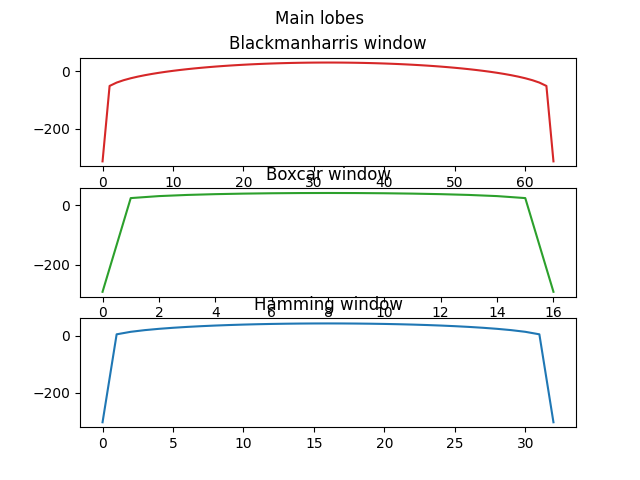

'\nThe 0 padding factor is how many times bigger the FFT buffer is  \ncomparing to the window size (that is, the number of samples we analyse in a STFT).\nIn fact, it is calculated by dividing the FFT size by the corresponding window size.\nIf we then divide the main lobe width by the 0 padding factor, we obtain the "original"\nmain lobe width for each window applied (in these cases, blackmanharris, boxcar and hamming).\nThese main lobe widths correspond to the ones presented in class with the slides.\n\nIn other words, each (time domain) window has a frequency spectrum shape, with a main lobe of a MINIMUM width\n(e.g. Blackmanharris is 8 bins wide).\nBy increasing the window size we can add resolution in the frequency domain (make the whole sinc-function like "shape"\nof the window\'s magnitude spectrum narrower, so that, the same main lobe width looks narrower because we have \nmore bins, that is, frequency resolution), and by adding 0 padding we can increase interpolation in the fre

In [3]:
# E4 - 1.2: Call extract_main_lobe() with the 3 test cases mentioned and plot the magnitude spectra of the windows with 
# the location of the main-lobe boundaries. Compute and explain the normalized main-lobe width (dividing by the 
# zero-padding factor), comparing it with the values presented in the theory.

### Your code here

mainLobe_A = extract_main_lobe('blackmanharris', 100, 800)
norm_mainLobeA_width = int(len(mainLobe_A) / 8)
print("norm_mainLobeA_width (blackmanharris);")
print(norm_mainLobeA_width)

mainLobe_B = extract_main_lobe('boxcar', 120, 960)
norm_mainLobeB_width = int(len(mainLobe_B) / (960/120))
print("norm_mainLobeB_width (boxcar);")
print(norm_mainLobeB_width)

mainLobe_C = extract_main_lobe('hamming', 256, 2048)
norm_mainLobeC_width = int(len(mainLobe_C) / (2048/256))
print("norm_mainLobeC_width (hamming);")
print(norm_mainLobeC_width)

fig, axs = plt.subplots(3)
fig.suptitle('Main lobes')
axs[0].plot(np.arange(len(mainLobe_A)), mainLobe_A, 'tab:red')
axs[0].set_title('Blackmanharris window')
axs[1].plot(np.arange(len(mainLobe_B)), mainLobe_B, 'tab:green')
axs[1].set_title('Boxcar window')
axs[2].plot(np.arange(len(mainLobe_C)), mainLobe_C, 'tab:blue')
axs[2].set_title('Hamming window')

"""
The 0 padding factor is how many times bigger the FFT buffer is  
comparing to the window size (that is, the number of samples we analyse in a STFT).
In fact, it is calculated by dividing the FFT size by the corresponding window size.
If we then divide the main lobe width by the 0 padding factor, we obtain the "original"
main lobe width for each window applied (in these cases, blackmanharris, boxcar and hamming).
These main lobe widths correspond to the ones presented in class with the slides.

In other words, each (time domain) window has a frequency spectrum shape, with a main lobe of a MINIMUM width
(e.g. Blackmanharris is 8 bins wide).
By increasing the window size we can add resolution in the frequency domain (make the whole sinc-function like "shape"
of the window's magnitude spectrum narrower, so that, the same main lobe width looks narrower because we have 
more bins, that is, frequency resolution), and by adding 0 padding we can increase interpolation in the frequency domain.

Basically, the main lobe width, for each window, remains the same for any window size, but enlarging the
window size of course makes the same main lobe looking much narrower because we take into account many more samples.
0 padding, enlarges the main lobe width (as well as it enlarges the whole window magnitude spectrum shape),
as we saw in this exercise, but 0 padding does not add any frequency domain resolution,
it only adds discrete interpolation.
"""

## Part 2 - Measuring noise in the reconstructed signal using the STFT model 

The function `compute_snr()` should measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise. 
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length. 

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values. 

In [4]:
# E4 - 2.1: Complete function compute_snr()
import IPython.display as ipd

def compute_snr(input_file, window, M, N, H):
    """Measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model.
    
    Args:
        input_file (str): wav file name including the path 
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window length (odd positive integer)
        N (int): fft size (power of two, > M)
        H (int): hop size for the stft computation
            
    Result:
        tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    ### your code here
    
    # fs is the sampling rate, x is the time domain samples array of the input signal
    fs, x = UF.wavread(input_file)
    
    # OPTIONAL (debug) ; play input signal
    ipd.display(ipd.Audio(rate=fs, data=x))
    
    w = get_window(window, M)
    
    # y is the reconstructed time domain signal after STFT analysis (conversion to 
    # frequency domain) and resynthesis
    y = stft.stft(x, w, N, H)
    
    # OPTIONAL (debug) ; play output signal
    ipd.display(ipd.Audio(rate=fs, data=y))
    
    """
    THE NOISE IS CALCULATED AS A DIFFERENCE BETWEEN THE INPUT SIGNAL
    AND THE OUTPUT SIGNAL.
    THE ENERGY OF A SIGNAL IS THE SUM OF THE SQUARES OF EACH SAMPLE OF A SIGNAL.
    THE SIGNAL TO NOISE RATIO IS THE DIVISION BETWEEN THE ENERGY OF THE OUTPUT SIGNAL
    AND THE ENERGY OF THE NOISE.
    """
    
    # SNR1
    
    array = np.arange(4)
    test = np.sum(pow(array, 2))
    
    # Calculate noise
    noise1 = x - y
    # Calulcate output signal and noise energy
    yE = np.sum(pow(y, 2))
    noiseE = np.sum(pow(noise1, 2))
    # Calculate SNR1
    SNR1 = 10 * np.log10(yE / noiseE)
    
    # OPTIONAL plot input and output signals
    """
    print("len(x);")
    print(len(x))
    print("len(y);")
    print(len(y))
    fig, axs = plt.subplots(2)
    fig.suptitle('Input and output signals')
    axs[0].plot(np.arange(len(x)), x, 'tab:red')
    axs[0].set_title('Input')
    axs[1].plot(np.arange(len(y)), y, 'tab:green')
    axs[1].set_title('Output')
    """
    
    # SNR2
    partOf_x = np.zeros(len(x)-(M*2))
    partOf_y = np.zeros(len(y)-(M*2))
    
    """
    print("len(partOf_x);")
    print(len(partOf_x))
    print("len(partOf_y);")
    print(len(partOf_y))
    """
    
    partOf_x = x[M-1:len(x)-1-M]
    partOf_y = y[M-1:len(y)-1-M]
    
    # Calculate noise
    noise2 = partOf_x - partOf_y
    # Calulcate output signal and noise energy
    partOf_yE = np.sum(pow(partOf_y, 2))
    noiseE_part = np.sum(pow(noise2, 2))
    
    # Calculate SNR2
    SNR2 = 10 * np.log10(partOf_yE / noiseE_part)
    
    # OPTIONAL plot sliced input and sliced output signals
    """
    fig, axs = plt.subplots(2)
    fig.suptitle('Sliced input and output signals')
    axs[0].plot(np.arange(len(partOf_x)), partOf_x, 'tab:red')
    axs[0].set_title('Sliced Input')
    axs[1].plot(np.arange(len(partOf_y)), partOf_y, 'tab:green')
    axs[1].set_title('Sliced Output')
    """
    
    return SNR1, SNR2

Test cases for the function `compute_snr()`:

_Test case 1:_ If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(67.57748352378475, 86.35716169253175)`.

_Test case 2:_ If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`, 
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

_Test case 3:_ If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your output values can differ substantially.

In [5]:
# E4 - 2.2: Call the function compute_snr() for the 3 test cases mentioned, explain the results

### Your code here

SNR1, SNR2 = compute_snr("../sounds/piano.wav", 'blackman', 513, 2048, 128)
print("Test case 1")
print("SNR1;")
print(SNR1)
print("SNR2;")
print(SNR2)

SNR1, SNR2 = compute_snr("../sounds/sax-phrase-short.wav", 'hamming', 512, 1024, 64)
print("Test case 2")
print("SNR1;")
print(SNR1)
print("SNR2;")
print(SNR2)

SNR1, SNR2 = compute_snr("../sounds/rain.wav", 'hann', 1024, 2048, 128)
print("Test case 3")
print("SNR1;")
print(SNR1)
print("SNR2;")
print(SNR2)

"""
In all test cases, the SNR is better ignoring the first M and last M samples of the input/output signals.
This is because the framing and 0-time-centering concepts of the STFT (the windowed input signal's frame
is indexed from N/2 to N/2+1, in order to apply 0 phase windowing in case of even window size)
introduce noise in the first and last frame.
In fact, half of the first frame is 0-valued, since the signal is empty before the first time sample.
Also hals of the last sample is 0-valued, since the signal is empty after the last time sample.
This introduces abrupt discontinuities, which result in high frequency content and hence noise in the frequency domain.
More precisely;
- Test case 1 and 2 have the same input signals; the SNR for the "sliced" signals is much better in test case 2,
because we have a smaller FFT size, and the problem of spectra leackage, mentioned above, introduced by the discontinuities
in the first and last frames become less evident.
- Test case 3 has a quite noisy sound as input signal, therefore is less likely to introduce distortion (as the energy calculation
takes into account a large span of frequencies squares sum, and does not exactly tells us WHERE on those frequencies
there is higher or lower SNR).
- If the window size is a (larger, integer) multiple of the hop size, SNR improves.

In test case 1, SNR is worst (lower) because the hop size is quite large comparing to the window size.
    And also, the hop size is bigger than 1/4th of the window size; this creates problems when
    performing overlap and add to reconstruct the original signal.
In test case 3, SNR is best (higher) because we have a larger window size (larger frequency resolution), and
an overall better time/frequency resolution compromise.

Also, in test case 1 (worse SNR) the window size is odd. Test case 2 and 3 (better SNR) have an even window size.

In theory, the STFT and ISTFT guarantee, apart from the first and last frames
where a part of the original input signal could not be recovered, unity (equality across whole samples)
between the input time domain signal and the output time domain signal, regardless
of the type of window applied (hamming, hanning, ecc.).
The window size and hop size are nevertheless fundamentally important parameters
for obtaining a correct overlap-and-add reconstruction of the signal and a real identity between input and output.
"""

Test case 1
SNR1;
67.54017992688655
SNR2;
86.35715759439309


Test case 2
SNR1;
89.5105065864743
SNR2;
306.4585669806006


Test case 3
SNR1;
74.6314734897444
SNR2;
305.46810387661975


'\nIn all test cases, the SNR is better ignoring the first M and last M samples of the input/output signals.\nThis is because the framing and 0-time-centering concepts of the STFT (the windowed input signal\'s frame\nis indexed from N/2 to N/2+1, in order to apply 0 phase windowing in case of even window size)\nintroduce noise in the first and last frame.\nIn fact, half of the first frame is 0-valued, since the signal is empty before the first time sample.\nAlso hals of the last sample is 0-valued, since the signal is empty after the last time sample.\nThis introduces abrupt discontinuities, which result in high frequency content and hence noise in the frequency domain.\nMore precisely;\n- Test case 1 and 2 have the same input signals; the SNR for the "sliced" signals is much better in test case 2,\nbecause we have a smaller FFT size, and the problem of spectra leackage, mentioned above, introduced by the discontinuities\nin the first and last frames become less evident.\n- Test case 3

## Part 3 - Computing band-wise energy envelopes of a signal

The function `compute_eng_env()` should compute band-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then you should compute the energy envelopes in decibels. 

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to find those bin indexes). This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [6]:
# E4 - 3.1: Complete function compute_eng_env()

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.
    
    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation
        
    Result:
        np.array: magnitude spectra of sound (2D array)
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    # mX is a matrix containing the magnitude spectrum for all frames
    # pX is a matrix containing the phase spectrum for all frames
    mX_dB, pX = stft.stftAnal(x, w, N, H)
    # Transform mX from dB (logarithmic) into linear scale
    # line of code from dftModel.py
    # mX = 20 * np.log10(absX)  # magnitude spectrum of positive frequencies in dB
    # Linear / logarithmic scales conversion formula:
    # 𝑎⋅log𝑏(𝑥)=log𝑏(𝑥 to the power of 𝑎)
    mX = np.log10(np.power(mX_dB, 20))
    
    num_frames = np.shape(mX)[0]
    
    # Compute, for each frequency bin, the frequency it represents in hZ
    fq_bins = np.arange(N)
    fq_bins_f = fq_bins * (fs / N)

    # find frequency bands' upper and lower borders frequency bins
    for k in range(len(fq_bins_f)):
        if (fq_bins_f[k] > 0):
            lfBand_lf = k
            break
            
        # count backwards
    for k in range(len(fq_bins_f)-1, 0, -1):
        if (fq_bins_f[k] < 3000):
            lfBand_hf = k
            break
            
    for k in range(len(fq_bins_f)):
        if (fq_bins_f[k] > 3000):
            hfBand_lf = k
            break
            
        # count backwards
    for k in range(len(fq_bins_f)-1, 0, -1):
        if (fq_bins_f[k] < 10000):
            hfBand_hf = k
            break
    
        # OPTIONAL debug
    print("lfBand_lf;")
    print(lfBand_lf)
    print("lfBand_hf;")
    print(lfBand_hf)
    print("hfBand_lf;")
    print(hfBand_lf)
    print("hfBand_hf;")
    print(hfBand_hf)
    
        # OPTIONAL debug
    """
    print("mX shape;")
    print(mX.shape)
    """
    # Python/Numpy's arrays and 2-D matrices are accessed and sliced by giving 2 indeces;
    # 1 for the number of row, 1 for the number of column
    # The mX matrix has numberOfFrames rows and fftSize/2 columns (we could say that the time dimension
    # increases from the top row to the bottom row, and the frequency dimension increases from the
    # left column to the right column)
    
    # So, we have to produce 2 matrices, both of which have to have the same number of rows
    # (corresponding to the same number of frames)
    # but different number of columns, depending on the selected frequency bins of the filtered bands
    
    
    lfBand_mX = np.zeros((num_frames, (lfBand_hf-lfBand_lf) + 1))
    print("lfBand_mX shape;")
    print(lfBand_mX.shape)
    for row_it in range(num_frames):
        lfBand_mX[row_it][:] = mX[row_it][lfBand_lf:lfBand_hf+1]
        
    hfBand_mX = np.zeros((num_frames, (hfBand_hf-hfBand_lf) + 1))
    print("hfBand_mX shape;")
    print(hfBand_mX.shape)
    for row_it in range(num_frames):
        hfBand_mX[row_it][:] = mX[row_it][hfBand_lf:hfBand_hf+1]

    # Computer Energy envelope for each frame
    # Since, for each frame, it is the sum of the amplitude of all frequencies, it is not a matrix anymore, but an array
    E_lfBand = np.zeros(num_frames)
    for l in range(num_frames):
        for k in range(np.shape(lfBand_mX)[1]):
            E_lfBand[l] += np.square(lfBand_mX[l,k])
        
    E_hfBand = np.zeros(num_frames)
    for l in range(num_frames):
        for k in range(np.shape(hfBand_mX)[1]):
            E_hfBand[l] += np.square(hfBand_mX[l,k])
        
    bands_E_envelope = np.zeros((num_frames,2))
    for l in range(num_frames):
        bands_E_envelope[l,0] = E_lfBand[l]
        bands_E_envelope[l,1] = E_hfBand[l]
        
    # Converting back the Energy to logarithmic scale
    # 𝐸𝑑𝐵=10log10(𝐸)
    bands_E_envelope = 10 * np.log10(bands_E_envelope)
    
    """
    print("bands_E_envelope shape;")
    print(bands_E_envelope.shape)
    """
    
    return bands_E_envelope # array with num_frames rows and 2 columns (1 for each frequency band)

Test cases for the function `compute_eng_env()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the band-wise energy envelope and its characteristics you can plot the envelopes together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. To visualize the spectrogram of a signal, a good option is to use the function `colormesh()` (you can reuse the code in
`lectures/4-STFT/plots-code/spectrogram.py`). Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the spectrogram and the energy envelopes.

You can clearly notice the sharp attacks and decay of the piano notes for test case 1. You can compare this with the output from test case 2 that uses a larger window. You can infer the influence of window size on sharpness of the note attacks.

lfBand_lf;
1
lfBand_hf;
69
hfBand_lf;
70
hfBand_hf;
232
lfBand_mX shape;
(1325, 69)
hfBand_mX shape;
(1325, 163)


<IPython.core.display.Javascript object>


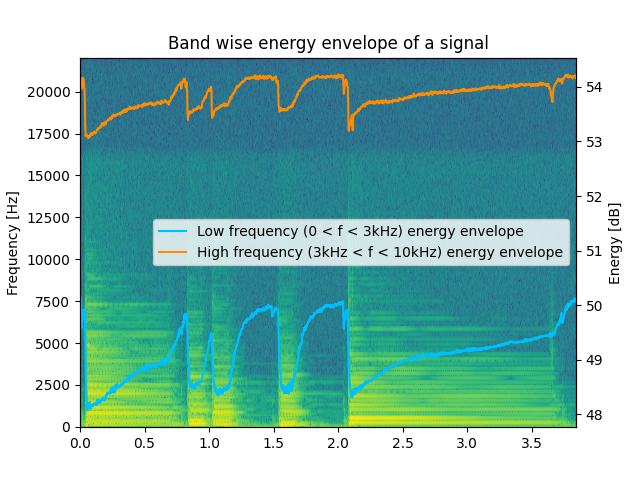

lfBand_lf;
1
lfBand_hf;
278
hfBand_lf;
279
hfBand_hf;
928
lfBand_mX shape;
(1325, 278)
hfBand_mX shape;
(1325, 650)


<IPython.core.display.Javascript object>


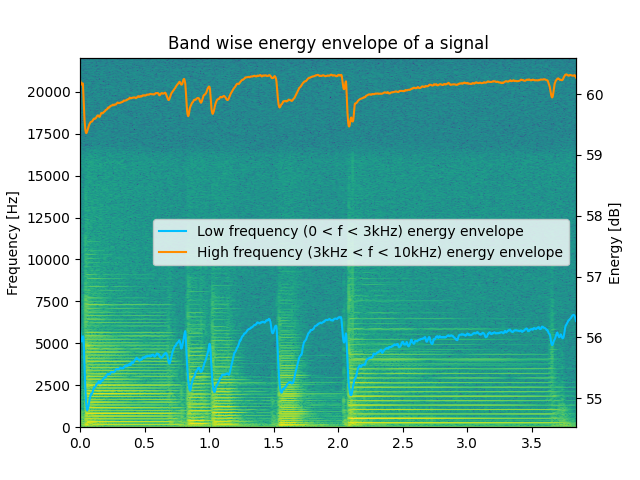

lfBand_lf;
1
lfBand_hf;
139
hfBand_lf;
140
hfBand_hf;
464
lfBand_mX shape;
(542, 139)
hfBand_mX shape;
(542, 325)


<IPython.core.display.Javascript object>


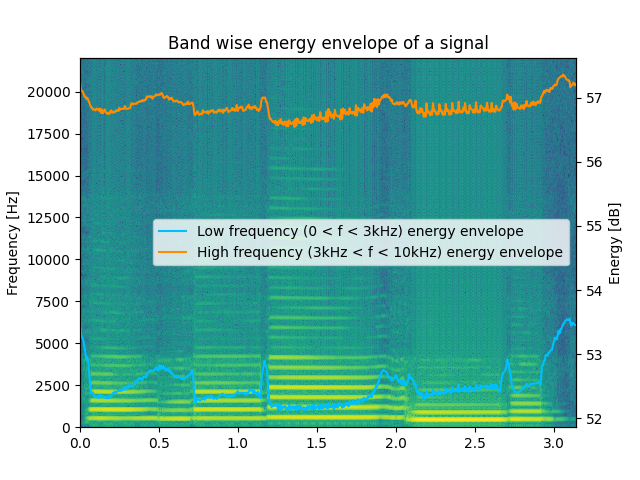

'\nThe band-wise energy envelope of a signal is, given a magnitude spectrum, the sum of the squares\nof the magnitude of each frequency bin within a particular range (contained within a frequency band).\n\nIt is an estimation of the energy concentrated in a particular frequency band, at each frame in time.\n'

In [8]:
# E4 - 3.2: Call the function compute_eng_env() and plot the envelopes together with the 
# spectrogram of the signal

### Your code here

# code from spectrogram.py

import numpy as np
import time, os, sys

# sys.path.append(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../software/models/'))

import stft as STFT
import utilFunctions as UF
import matplotlib.pyplot as plt
from scipy.signal import hamming
from scipy.fftpack import fft
import math

plot_title = 'Band wise energy envelope of a signal'

M = 513
N = 1024
H = 128
input_file = '../sounds/piano.wav'
window_type = 'blackman'
envs_1 = compute_eng_env(input_file, window_type, M, N, H)

(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, envs_1[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, envs_1[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()

M = 2047
N = 4096
H = 128
input_file = '../sounds/piano.wav'
window_type = 'blackman'
envs_2 = compute_eng_env(input_file, window_type, M, N, H)

(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, envs_2[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, envs_2[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()

M = 513
N = 2048
H = 256
input_file = '../sounds/sax-phrase-short.wav'
window_type = 'hamming'
envs_3 = compute_eng_env(input_file, window_type, M, N, H)

(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, envs_3[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, envs_3[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()

"""
The band-wise energy envelope of a signal is, given a magnitude spectrum, the sum of the squares
of the magnitude of each frequency bin within a particular range (contained within a frequency band).

It is an estimation of the energy concentrated in a particular frequency band, at each frame in time.
"""

## Part 4 - Computing onset detection function

The function `compute_odf()` should compute a simple onset detection function (ODF) using the STFT. It should compute two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF. 

The input arguments to the function are the wav file name including the path (`input_file`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the ODF computed on the low frequency band and the 
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [9]:
# E4 4.1: Complete function compute_odf()

def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.
    
    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation
        
    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    # mX is a matrix containing the magnitude spectrum for all frames
    # pX is a matrix containing the phase spectrum for all frames
    mX, pX = stft.stftAnal(x, w, N, H)
    num_frames = np.shape(mX)[0]
    
    envE = compute_eng_env(input_file, window, M, N, H)

    # calculating onset detection function
    # The ODF is a series of scalar values, one for each frame, telling us the difference in energy
    # for each consecutive frame (each frame is compared to the previous one)
    # For each frame, it is the difference between the current frame's energy
    # and the previous frame's energy
    ODF = np.zeros((num_frames,2))
    
    # l represents the frame/time iterator (rows)
    # 0 and 1 represents the columns of the matrix (0 -> lower band, 1 -> upper band)
    for l in range(1, num_frames):
        ODF[l][0] = envE[l][0] - envE[l-1][0]
        # half way rectification of lower band (detect only on-sets, not off-sets)
        if (ODF[l][0] < 0.0):
            ODF[l][0] = 0.0
        ODF[l][1] = envE[l][1] - envE[l-1][1]
        # half way rectification of upper band (detect only on-sets, not off-sets)
        if (ODF[l][1] < 0.0):
            ODF[l][1] = 0.0
            
    """
    # normalize
    ODF[:][0] = ODF[:][0] / max(ODF[:][0])
    ODF[:][1] = ODF[:][1] / max(ODF[:][1])
    """
    
    return ODF


Test cases for the function `compute_odf()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). 

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). 

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the ODFs and their characteristics you can plot the ODF functions together with the spectrogram of the signal. Use the same plotting than in the previos part.

In order to identify the actual onsets of a signal you would need to find the peaks, local maxima, of the ODF functions using a magnitude threshold. Which of the 2 ODFs (low or high frequencies) would be most useful? What would be the right threshold for all 3 cases? Could you find a single threshold to be used for all 3 cases?

For test case 1, you should clearly see that the ODFs have sharp peaks at the onset of the piano notes. You should notice 5 peaks that are above 10dB value in the ODF computed on the high frequency band. 

lfBand_lf;
1
lfBand_hf;
69
hfBand_lf;
70
hfBand_hf;
232
lfBand_mX shape;
(1325, 69)
hfBand_mX shape;
(1325, 163)
lfBand_lf;
1
lfBand_hf;
69
hfBand_lf;
70
hfBand_hf;
232
lfBand_mX shape;
(1325, 69)
hfBand_mX shape;
(1325, 163)


<IPython.core.display.Javascript object>


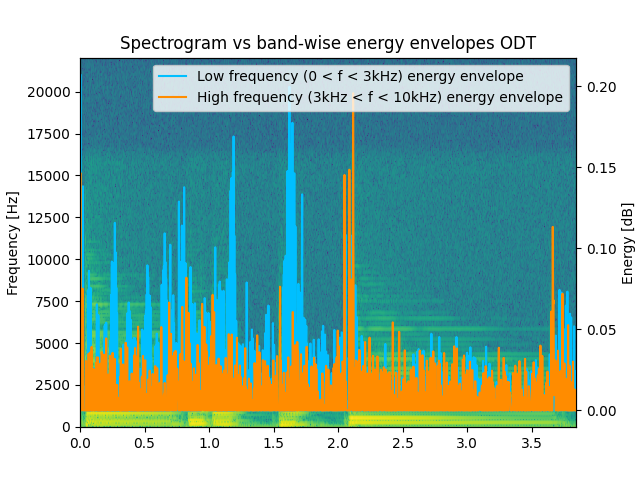

lfBand_lf;
1
lfBand_hf;
278
hfBand_lf;
279
hfBand_hf;
928
lfBand_mX shape;
(1325, 278)
hfBand_mX shape;
(1325, 650)
lfBand_lf;
1
lfBand_hf;
278
hfBand_lf;
279
hfBand_hf;
928
lfBand_mX shape;
(1325, 278)
hfBand_mX shape;
(1325, 650)


<IPython.core.display.Javascript object>


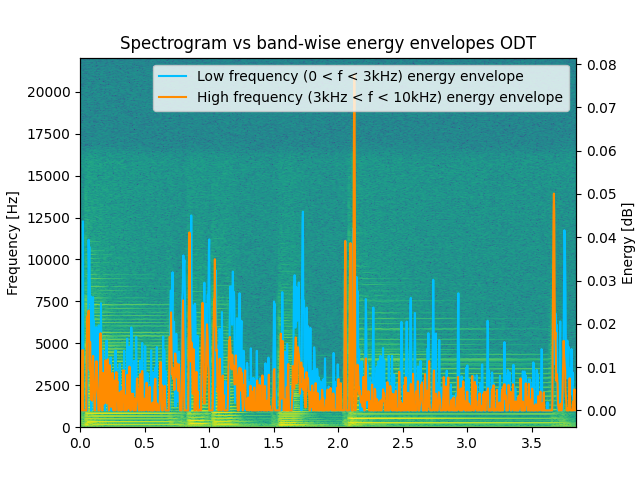

lfBand_lf;
1
lfBand_hf;
139
hfBand_lf;
140
hfBand_hf;
464
lfBand_mX shape;
(542, 139)
hfBand_mX shape;
(542, 325)
lfBand_lf;
1
lfBand_hf;
139
hfBand_lf;
140
hfBand_hf;
464
lfBand_mX shape;
(542, 139)
hfBand_mX shape;
(542, 325)


<IPython.core.display.Javascript object>


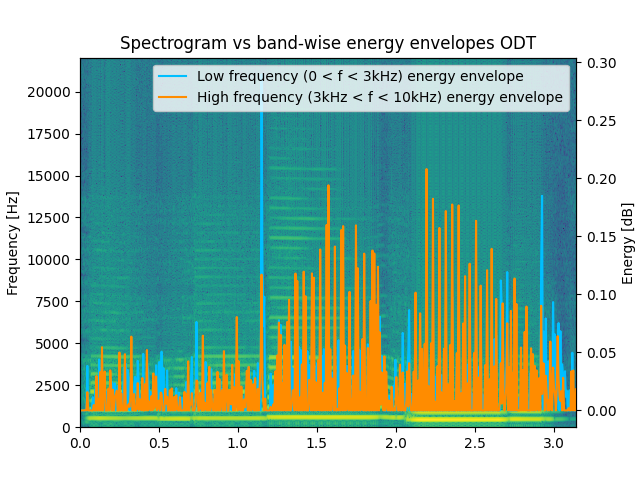

In [10]:
# E4 - 4.2: Call the function compute_odf() for the 3 test cases and plot the ODF functions together with the 
# spectrogram of the signal.

### Your code here
plot_title = "Spectrogram vs band-wise energy envelopes ODT"

# TEST CASE 1
M = 513
N = 1024
H = 128
input_file = '../sounds/piano.wav'
window_type = 'blackman'
envs_2 = compute_eng_env(input_file, window_type, M, N, H)
(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

odf = compute_odf(input_file, window_type, M, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, odf[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, odf[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()


# TEST CASE 2
M = 2047
N = 4096
H = 128
input_file = '../sounds/piano.wav'
window_type = 'blackman'
envs_2 = compute_eng_env(input_file, window_type, M, N, H)
(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

odf = compute_odf(input_file, window_type, M, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, odf[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, odf[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()


# TEST CASE 3
M = 513
N = 2048
H = 256
input_file = '../sounds/sax-phrase-short.wav'
window_type = 'hamming'
envs_2 = compute_eng_env(input_file, window_type, M, N, H)
(fs, x) = UF.wavread(input_file)
w = get_window(window_type, M)
mX, pX = STFT.stftAnal(x, w, N, H)

odf = compute_odf(input_file, window_type, M, N, H)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, odf[:,0], color = 'deepskyblue', label = "Low frequency (0 < f < 3kHz) energy envelope")
ax2.plot(tAxis, odf[:,1], color = 'darkorange',label = "High frequency (3kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()

In [133]:
# E4 - 4.3: Explain the results of Part 4
'''
In the first 2 examples, we can see the difference in time/frequency resolution compromise;
the shorter window size of test case 1 provides a lower frequency resolution but a better time resolution.
Viceversa for test case 2, which has a larger window size.
I think that, for detecting the on-sets, priority should be given to the time resolution (test case 1 is better,
I think this can be seen also by looking at the spectrogram).

ODT of the upper frequency bands is, as expected, noisier than the one of the lower frequency band.
This is why the higher frequency band (3 KhZ - 10 KhZ) is more likely to contain the transients' noise/high frequencies spikes.
It is interesting to note how the time behavior of the high frequencies varies much between the 2 different sounds (piano and saxophone).
As the piano sounds has quite clear sharp transient attacks, the saxophone has a kind of "faded-in" high frequencies
partials/noise amount, happening after the actual onset (this is reasonably intuitive if we think that
a piano player can not control the decay/sustain/release time, while a saxophone player can control and modulate those
parameters over time).
So, I would say that for detecting onsets on a piano sound it's better to use the upper frequency band,
while for detecting onsets on a saxophone sound it is better to use the lower frequency band.

I don't think we can suggest a single threshold value (valid for all 3 cases) for detecting the onsets out of the ODF.
I would use the following threshold values;
-test case 1; 0.05 (upper band)
-test case 2; 0.02 (upper band)
-test case 3; 0.04 (lower band)
'''


'\n\n\n'